Import dependencies and hide warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx

from numpy.random import seed
from pysal.explore import esda
from pysal.lib import weights
from splot import esda as esdaplot
from src.functions.stats_utils import plot_corr_matrix

plt.style.use("./src/style.mplstyle")

# Spatial Analysis of Domestic Violence Cases in the Colombian Caribbean Region

In this repo we analize the domestic violence cases in Colombian Caribbean Region from 2010 to 2021, we correlate the domestic violence cases with some dempographic indicators and determined the global and local spatial autocorrelation of domestic violence cases.

Load data and show information about the variable of interest, where:

* ``STP27_PERS`` is the total population.
* ``DVCper1000iH`` is the rate of domestic violence cases reported by city for each 1000 inhabitants.
* ``PercentageAdultinPrimary`` is the percentage of adult that only has reached the elementary school.
* ``PercentageLSL`` is the percentage of houses in the lowest socioenomical level by city.
* ``PercentageHWES`` is the percentages of houses without electric supplies.
* ``PercentageHWWS`` is the percentages of houses without water supplies.

In [2]:
data_path = "./data/processed/domestic_violence_cases.gpkg"
layer_name = "Domestic Violence Cases"

variables = [
    "City",
    "STP27_PERS",
    "DomesticViolenceCases",
    "DVCper1000iH",
    "PercentageAdultinPrimary", 
    "PercentageLSL", 
    "PercentageHWES", 
    "PercentageHWWS",
    "WomenperMen",
    "geometry"
]

gdf = gpd.read_file(data_path, layer=layer_name).loc[:,variables]
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   City                      195 non-null    object  
 1   STP27_PERS                195 non-null    float64 
 2   DomesticViolenceCases     195 non-null    float64 
 3   DVCper1000iH              195 non-null    float64 
 4   PercentageAdultinPrimary  195 non-null    float64 
 5   PercentageLSL             195 non-null    float64 
 6   PercentageHWES            195 non-null    float64 
 7   PercentageHWWS            195 non-null    float64 
 8   WomenperMen               195 non-null    float64 
 9   geometry                  195 non-null    geometry
dtypes: float64(8), geometry(1), object(1)
memory usage: 15.4+ KB


## Explore Data

If we see the top ten cities with the higher number of domestic violence cases reported, and compare it with the top ten populated cities we can figure that ther is a correlation between domestic violence cases reported and population.

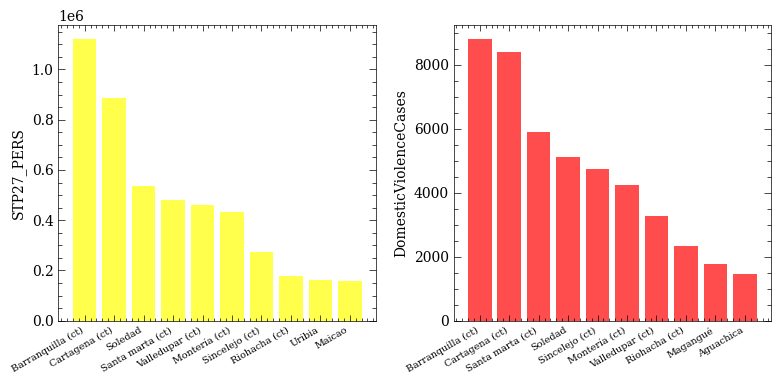

In [3]:
variables = ["STP27_PERS", "DomesticViolenceCases"]
colors = ["yellow", "red"]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

for var, color, ax in zip(variables, colors, axs):
    ax.bar(
        x=gdf.sort_values(var, ascending=False).City.iloc[:10],
        height=gdf.sort_values(var, ascending=False)[var].iloc[:10],
        color=color,
        alpha=0.7,
    )

    ax.set_ylabel(var)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right", fontsize="xx-small")

plt.show()

Also we can confirm this with an scatter plot of population against domestic violence cases.

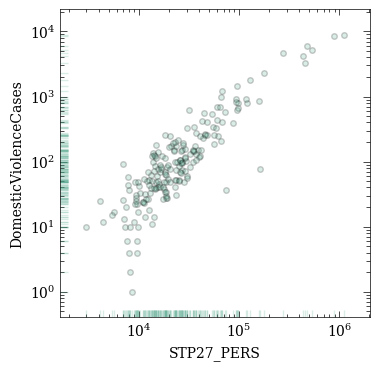

In [4]:
fig, ax = plt.subplots(1)

ax.scatter(
    x=gdf.STP27_PERS,
    y=gdf.DomesticViolenceCases,
    alpha=0.2,
)

sns.rugplot(x=gdf.STP27_PERS, y=gdf.DomesticViolenceCases, alpha=0.2, ax=ax)

ax.set(xlabel="STP27_PERS", ylabel="DomesticViolenceCases")
ax.set_xscale("log")
ax.set_yscale("log")

plt.show()

So, if we want to analyze the the spatial autocorrelation of the domestic violence cases we have to rid off the population bias, to perform this, we previously calculated the the rate of domestic violence cases per 1000 inhabitants.

The domestic violence cases per 1000 in habitants by city varies from ~0 to ~20 they are biased to the lower values with great representation of values between ~0 to ~5 with ~60% of the cases.

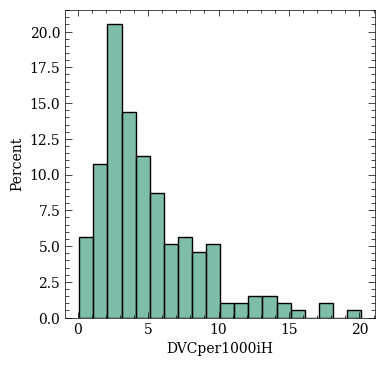

In [5]:
fig, ax = plt.subplots(1)

sns.histplot(
    gdf.DVCper1000iH,
    binwidth=1,
    stat="percent", 
    alpha=0.7, 
    ax=ax,
)

plt.show()

If we ploth the domestic violence cases per 1000 in habitants we can see that there are too many cities in the top ten most violent from Sucre, Bolívar amd Cordoba, departamentos at the south-west part of the Caribbean region. The choropleth map the same patter with another spot of violent cities at the Sierra Nevada of Santa Marta.

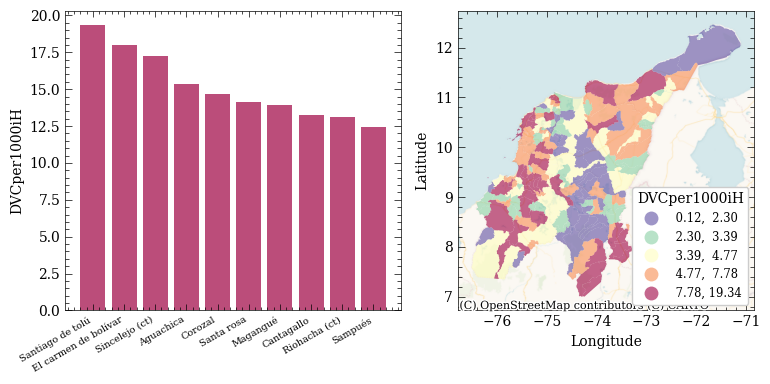

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

axs[0].bar(
    x=gdf.sort_values("DVCper1000iH", ascending=False).City.iloc[:10],
    height=gdf.sort_values("DVCper1000iH", ascending=False).DVCper1000iH.iloc[:10],
    color="#9e0142",
    alpha=0.7,
)

axs[0].set_ylabel("DVCper1000iH")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30, ha="right", fontsize="xx-small")

gdf.plot(
    column="DVCper1000iH",
    scheme="quantiles",
    cmap="Spectral_r",
    alpha=0.6,
    legend=True,
    legend_kwds=dict(loc=4, fontsize="x-small", title="DVCper1000iH", frameon=True),
    ax=axs[1],
)

cx.add_basemap(
    ax=axs[1],
    crs=gdf.crs.to_string(),
    source=cx.providers.CartoDB.VoyagerNoLabels,
)

axs[1].set(xlabel="Longitude", ylabel="Latitude")

plt.show()

With our variable of ineterest we can see how its change due to the effect the socioeconomical indicators early presented.

The regression plots show that there is a low possitive correlation between the domestic violence cases per 1000 in habitants and the ratio of women per men, also, there is a low negative correlation between the domestic violence cases per 1000 in habitants and the ge of adults who do not pass the elementary school.

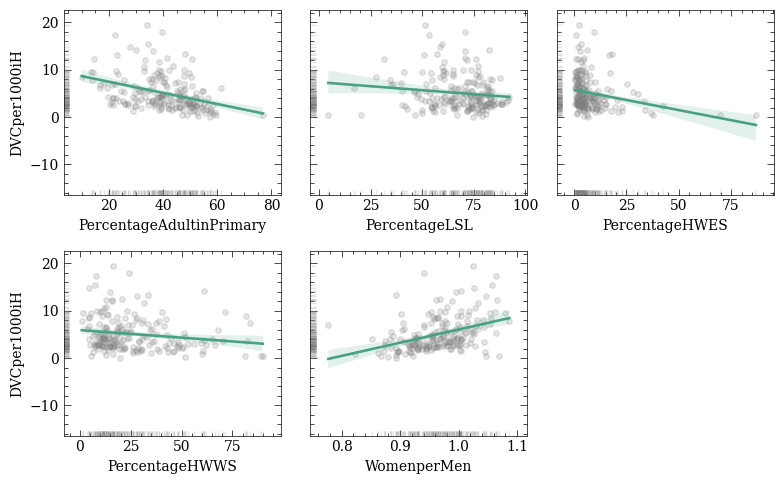

In [7]:
variables = [
    "PercentageAdultinPrimary", 
    "PercentageLSL", 
    "PercentageHWES", 
    "PercentageHWWS", 
    "WomenperMen"
]

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(8, 5), tight_layout=True)
axs = axs.reshape(-1)

for i, (var, ax) in enumerate(zip(variables, axs)):
    sns.regplot(
        x=var,
        y="DVCper1000iH",
        data=gdf,
        scatter_kws=dict(color="gray", alpha=0.2),
        ax=ax,
    )

    sns.rugplot(
        x=var,
        y="DVCper1000iH",
        data=gdf,
        color="gray",
        alpha=0.2,
        ax=ax,
    )

    if not(i in (0, 3)):
        ax.set_ylabel(None)

axs[-1].axis("off")

plt.show()

The correlation matrix confirm the correlation described before and show us that they are significants, so we can correlate more domestic violence report to cities where the women population is greater than the men population and cities where more adults pass the elementary school.

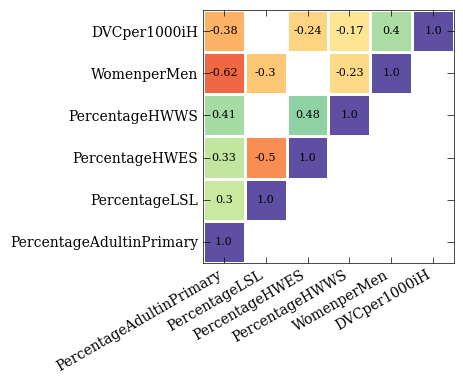

In [8]:
fig, ax = plt.subplots(1, figsize=(4.8, 4), tight_layout=True)

plot_corr_matrix(
    data=gdf, 
    variables=variables+["DVCper1000iH"], 
    half=True, 
    hide_insignificants=True, 
    ax=ax
)

plt.show()

## Global Spatial Autocorrelation

Now we can do a global spatial autocorrelation test to see if there is correlation between the value domestic violence cases per 1000 in habitants in one city with the values of its surrounding cities.

First we have to reproject the data to a projected CRS:

In [9]:
gdf = gdf.to_crs("32618")

Now we have to calculate the lagged domestic violence cases per 1000 in habitants, that is the mean of the values of the neighbors of each city. To perform this we have to get the weights for each city and then, calculate the lagged data:

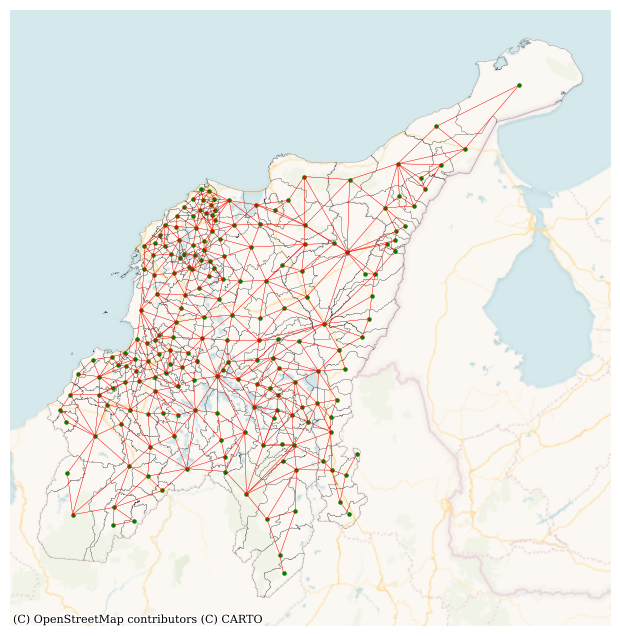

In [10]:
w = weights.Queen.from_dataframe(gdf)
w.transform = "R"

fig, ax = plt.subplots(1, figsize=(8, 8))

gdf.boundary.plot(
    edgecolor="black",
    linewidth=0.1,
    ax=ax,
)

w.plot(
    gdf,
    edge_kws=dict(color="red", linewidth=0.2),
    node_kws=dict(color="green", s=5),
    ax=ax,
)

cx.add_basemap(
    ax=ax,
    crs=gdf.crs.to_string(),
    source=cx.providers.CartoDB.VoyagerNoLabels,
)

ax.axis("off")

plt.show()

If we compare how looks the lagged domestic violence cases per 1000 in habitants with the original data we can see more clearly the two hot spots of domestic violence cases per 1000 in habitants in the south-west part of the region and at Sierra Nevada of Santa Marta, also, is more clear de cold spot at the center of the Caribbean Region (on the Magdalena River Banks).

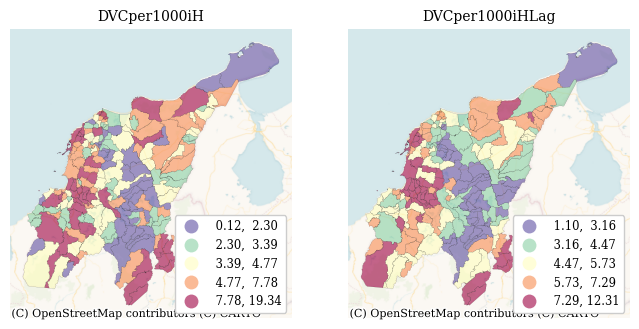

In [11]:
gdf["DVCper1000iHLag"] = weights.spatial_lag.lag_spatial(w, gdf.DVCper1000iH)

variables = ["DVCper1000iH", "DVCper1000iHLag"]

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for var, ax in zip(variables, axs):
    gdf.plot(
        column=var,
        scheme="quantiles",
        k=5,
        cmap="Spectral_r",
        alpha=0.6,
        edgecolor="black",
        linewidth=0.1,
        legend=True,
        legend_kwds=dict(loc=4, fontsize="x-small", frameon=True),
        ax=ax,
    )

    cx.add_basemap(
        ax=ax,
        crs=gdf.crs.to_string(),
        source=cx.providers.CartoDB.VoyagerNoLabels,
    )

    ax.axis("off")
    ax.set_title(var)

plt.show()

The Moran's Autocorrelation plot show that there is a correlation between the domestic violence cases per 1000 in habitants of a city and its neighbors, there values in the Lower-Lower quadrant (LL, in the map de cold spots) are more clustered suggesting that there are more correlated that the cities in the High-High quadrant (HH, the hot spots in the map)

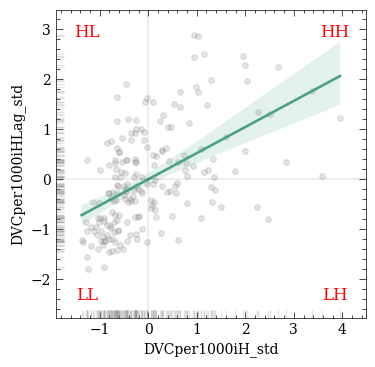

In [12]:
gdf["DVCper1000iH_std"] = (
    (gdf.DVCper1000iH - gdf.DVCper1000iH.mean())/gdf.DVCper1000iH.std()
)

gdf["DVCper1000iHLag_std"] = (
    (gdf.DVCper1000iHLag - gdf.DVCper1000iHLag.mean())/gdf.DVCper1000iHLag.std()
)

fig, ax = plt.subplots(1)

sns.regplot(
    x="DVCper1000iH_std",
    y="DVCper1000iHLag_std",
    data=gdf,
    scatter_kws=dict(color="gray", alpha=0.2),
    ax=ax,
)

sns.rugplot(
    x="DVCper1000iH_std",
    y="DVCper1000iHLag_std",
    data=gdf,
    color="gray",
    alpha=0.2,
    ax=ax,
)

ax.axvline(0, linewidth=0.1, color="black")
ax.axhline(0, linewidth=0.1, color="black")

ax.text(0.9, 0.9, "HH", color="red", ha="center", va="bottom", transform=ax.transAxes)
ax.text(0.9, 0.1, "LH", color="red", ha="center", va="top", transform=ax.transAxes)
ax.text(0.1, 0.1, "LL", color="red", ha="center", va="top", transform=ax.transAxes)
ax.text(0.1, 0.9, "HL", color="red", ha="center", va="bottom", transform=ax.transAxes)

plt.show()

The Moran test return us a Moran's I of 0.348 that indcate that there is a global spatial autocorrelation, en de p-value lower than the significance of 0.05 tell us that the spatial autocorrelation is significant.

In [13]:
m = esda.moran.Moran(gdf.DVCper1000iH, w)
print(f"Moran's I: {m.I:0.3f} (p-value: {m.p_norm:0.3f})")

Moran's I: 0.348 (p-value: 0.000)


The Moran's I Plot tell us that our autocorrelation values does not coresspond to a random distribution

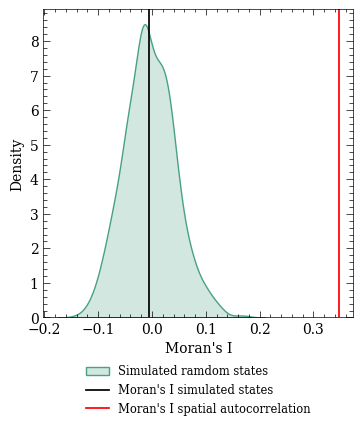

In [14]:
fig, ax = plt.subplots(1)

sns.kdeplot(m.sim, shade=True, ax=ax, label="Simulated ramdom states")
ax.axvline(m.EI, color="black", label="Moran's I simulated states")
ax.axvline(m.I, color="red", label="Moran's I spatial autocorrelation")

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), fontsize="x-small")

ax.set_xlabel("Moran's I")

plt.show()

## Local Spatial Autocorrelation

With LISA we can test the local spatial autocorrelation, this test show us that the amount of value with a positive autocorrelation (HH or LL) is higher than the amount of values with negative utocorrelation.

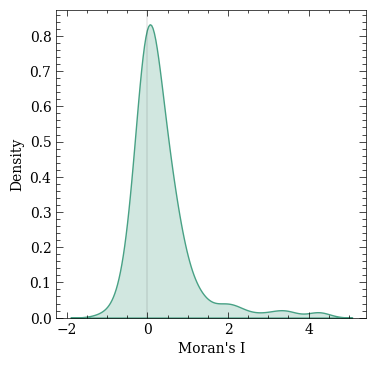

In [15]:
lisa = esda.moran.Moran_Local(gdf.DVCper1000iH, w)

fig, ax = plt.subplots(1)
sns.kdeplot(lisa.Is, shade=True, ax=ax)

ax.axvline(0, linewidth=0.1, color="black")

ax.set_xlabel("Moran's I")

plt.show()

The autocorrelation map show us that despite of the thw two hot spots identified only the greater at the south-west part of the region is significant, and the cold spot at the Magdalena River Bank is significative

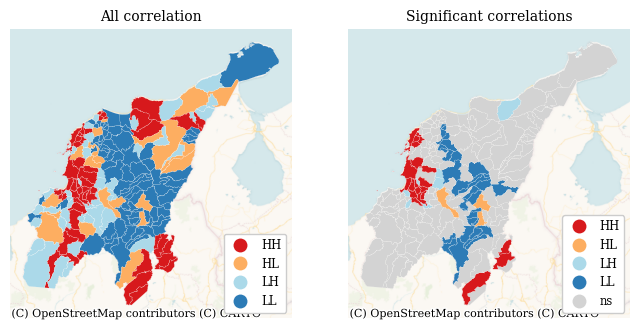

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for s, title, ax in zip((1, 0.05), ("All correlation", "Significant correlations"), axs):
    esdaplot.lisa_cluster(
        lisa,
        gdf,
        p=s,
        legend_kwds=dict(loc=4, fontsize="x-small", frameon=True),
        ax=ax,
    )

    cx.add_basemap(
        ax=ax,
        crs=gdf.crs.to_string(),
        source=cx.providers.CartoDB.VoyagerNoLabels,
    )

    ax.set_title(title)

To see how many cities has a significant spatial autocorrelation we create the variable for the p_value, the significance and the quadrant.

In [17]:
# Find what are the significant cities
gdf["p_value"] = lisa.p_sim
gdf["sig"] = 1 * (gdf.p_value < 0.05)

# Set quadrant labels
gdf["spot"] = lisa.q * gdf.sig
gdf["quadrant"] = gdf.spot.map({0: "ns", 1: "HH", 2: "LH", 3: "LL", 4: "HL"})

# Print classified
print(gdf.quadrant.value_counts())

ns    134
LL     29
HH     22
LH      7
HL      3
Name: quadrant, dtype: int64


From the cities with high and significant autocorrelated values of domestic violence cases per 1000 in habitants we can see that Santigo the Tolú has the higher rate, the majority of the cities with high siginificant correlated values are from the Departamento of Sucre.

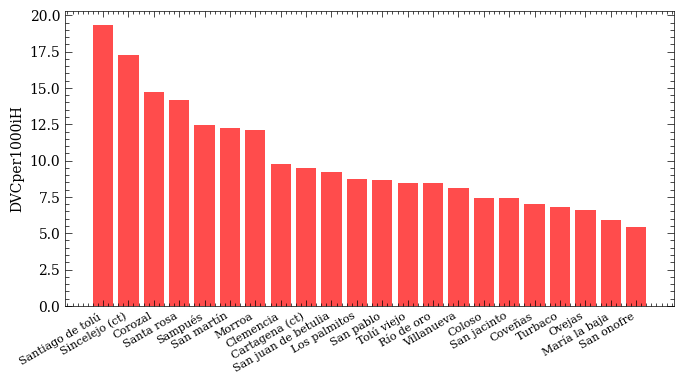

In [18]:
hh = (
    gdf.loc[gdf.quadrant == "HH", ["City", "DVCper1000iH"]]
        .sort_values("DVCper1000iH", ascending=False)
)

fig, ax = plt.subplots(1, figsize=(7, 4), tight_layout=True)

ax.bar(
    x=hh.City,
    height=hh.DVCper1000iH,
    color="red",
    alpha=0.7,
)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, rotation=30, ha="right")
ax.set_ylabel("DVCper1000iH")

plt.show()